### Project 5 Documentation

## Project 5: ARIMA Time Series forecasting

#### 1. Data Source:
- Task 1: NBP dataset, exchange rates bewteen PLN and THB
- Task 2: cryptocurrency exchange rates between USD and BTC


##### 2. Research purpose:

- For both PLN-THB and USD-BTC analysis:
    - Use the ADF-test to test the stationarity of the data
        - Def: A stochastic process is a stationary process, if its joint PDF does not change when shifted in time (if the process does not contain unit root)
        - If a process is stationary, its moments (e.g. mean, variance, skewness, kurtosis) do not change over time
    - Build the ARIMA model with parameters p,d,q; 
        - If the data is stationary: set d=0 (differentiation order)
        - If the data is not stationary, increase the differentiation order until it will be possible to reject the ADF-test H0 (or use a different I model)
    - Find parameters p,q (based on the ACF and PACF plots) that will fit the model the best
    - Build the ARIMA model, draw the validation plot to check goodness of fit.
    - If the goodness of fit is not sufficient, use a different integration model (the default I model is shift, however it is possible to use different models, and set the differentiation order d=0: log, exp_decay, sample - rolling mean etc)
    - Use the most optimal (in terms of the ADF-test and currency analysis) Integration model to fit the data
    - Build a different ARIMA model, draw the validation plot
    - Predict the exchange rates based on fitted ARIMA model
    - Draw conclusions

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import acf,pacf,plot_acf,plot_pacf
from pandas.plotting import register_matplotlib_converters
from datetime import timedelta
register_matplotlib_converters()
import warnings
warnings.simplefilter("ignore")

In [2]:
#confidence level
alpha = 0.05

In [3]:
class CurrencyAnalysis:
    def __init__(self,alpha,df_name,col,date_min,date_max,test_days=20,currency_name='',rolling_mean_window=12):
        # confidence level
        self.alpha=alpha
        # dataset
        self.df_name=df_name
        # column to analyze
        self.col=col
        self.currency_name=currency_name
        # The ARIMA model
        self.model=None
        # ARIMA model build results (cross-validation)
        self.results=None
        self.date_min=date_min
        self.date_max=date_max
        # The test data to display is chosen in range [date_max,date_test]
        self.date_test_min=self.date_max-timedelta(test_days)
        self.date_test=date_max+timedelta(days=test_days)
        # initialize the dataset
        self.df=self.read_df()
        # Parameter k of the MA model
        self.rwindow=rolling_mean_window
        self.test_days=test_days
        self.p,self.d,self.q=None,None,None
        
    @staticmethod
    def init_figure(size="normal",fig=None):
        figsize={
            "normal":(8,3.5),
            "small":(4.5,2.5),
            "double":(15,3)
        }
        if fig is None:
            fig=plt.gcf()
        # resize the matplotlib figure
        fig.set_size_inches(*figsize[size])
    
    def _read_df(self,index='Date'):
        # (default) read the BTC dataset (csv)
        df1=pd.read_csv(self.df_name)
        df1[index]=df1[index].apply(pd.to_datetime)
        df1=df1[(df1[index]>=date_min) & (df1[index]<=date_max)]
        df1=df1.set_index(index)
        df1[self.col]=df1[self.col].astype(float)
        return df1
    
    def read_df(self,index='Date'):
        try:
            return self._read_df(index)
        except:
            return self.parse_data2([self.col])
        
    def parse_data2(self,cols):
        # read the NBP dataset (xlsx)
        fname=self.df_name
        df=pd.read_excel(fname)
        df=df.iloc[1:237]
        df['Date']=df['data'].apply(pd.to_datetime)
        for x in cols:
            df[x]=df[x].astype(float)
        df['Open']=df[cols[0]]
        df=df[(df['Date']>=self.date_min) & (df['Date']<=self.date_max)]
        return df
    
    def _test(self,col='Open',index='Date',limits=None):
        # read the test dataset 1 (BTC-USD)
        df_test=pd.read_csv(self.df_name)
        df_test[index]=df_test[index].apply(pd.to_datetime)
        if limits is None:
            df_test=df_test[(df_test[index]>=self.date_test_min) & (df_test[index]<=self.date_test)]
        else:
            df_test=df_test[(df_test[index]>=limits[0]) & (df_test[index]<=limits[1])]
        df_test=df_test.set_index(index)
        df_test=df_test[self.col].astype(float)
        return df_test
    
    def test(self,col='Open',index='Date',limits=None):
        try:
            return self._test(col,index,limits)
        except:
            # read the test dataset 2 (PLN-THB)
            fname=self.df_name
            df=pd.read_excel(fname)
            df=df.iloc[1:237]
            df['Date']=df['data'].apply(pd.to_datetime)
            df[self.col]=df[self.col].astype(float)
            df['Open']=df[self.col]
            if limits is None:
                df=df[(df['Date']>=self.date_test_min) & (df['Date']<=self.date_test)]
            else:
                df=df[(df['Date']>=limits[0]) & (df['Date']<=limits[1])]
            return df['Open']
        
    def adf_test(self,df=None,col='Open',Integration_fun=None):
        # Implementation of the ADF-test
        if df is None:
            df=self.df_log()
        if Integration_fun is not None:
            df=Integration_fun(df)
        result = adfuller(df)
        print(col)
        print('ADF Statistic: {}'.format(result[0]))
        print('p-value: {}'.format(result[1]))
        print('Critical Values:')
        for key, value in result[4].items():
            print('\t{}: {}'.format(key, value))
    
    # Plot the rolling mean and std.
    def get_stationarity(self,timeseries,title='',ax=None):
        # rolling statistics (moving average and moving std.)
        rolling_mean = timeseries.rolling(window=self.rwindow).mean()
        rolling_std = timeseries.rolling(window=self.rwindow).std()
        # rolling statistics plot
        if ax is None:
            _ax=plt
        else:
            _ax=ax
        original = _ax.plot(timeseries, color='blue', label='Original')
        mean = _ax.plot(rolling_mean, color='red', label='Rolling Mean')
        std = _ax.plot(rolling_std, color='black', label='Rolling Std')
       
        _ax.legend(loc='best',prop={'size': 6})
        
        if ax is None:
            _ax.title(title)
            _ax.show(block=False)
        else:
            _ax.set_title(title)
    # Plot the rolling mean and std. && display the ADF-test results
    def stationarity(self,adf_test=True, Integration_fun=None,ax=None):
        if ax is None:
            self.init_figure()
        data=self.df_log()
        if Integration_fun is not None:
            data=Integration_fun(data)
        self.get_stationarity(data,self.currency_name,ax=ax)
        # Dickey–Fuller test:
        if adf_test:
            self.adf_test(Integration_fun=Integration_fun)
    
    # Integration model: df -> df - df.shift()
    def df_log_shift(self,plot=True):
        df_log = self.df_log()
        df_log_shift = df_log - df_log.shift()
        df_log_shift.dropna(inplace=True)
        if plot:
            self.init_figure()
            self.get_stationarity(df_log_shift,self.currency_name)
            self.adf_test(df_log_shift)
        return df_log_shift
    
    # Build the ARIMA model with parameters p (autoregressive terms), 
    # d (differentiation order), q (moving average window)
    def arima_build(self,p,d,q,plot=True,limits=None,Integration_fun=None,ax=None):
        self.p,self.d,self.q=p,d,q
        self.date_test_min-=timedelta(2*self.q+1)
        
        if ax is None and plot:
            plt.gcf().set_size_inches(4,2.5)
            plt.gca().axes.get_xaxis().set_visible(False)
        df_log=self.df_log()
        if limits is not None:
            df_log=df_log[limits[0]:limits[1]]
        #decomposition = seasonal_decompose(df_log)
        self.model = ARIMA(df_log, order=(p,d,q))
        self.results = self.model.fit()
        if ax is None:
            ax=plt
        else:
            ax.tick_params(axis = 'both', labelsize = 6)
        
        # shift is the default Integration model
        if Integration_fun is not None:
            data_test=Integration_fun(df_log)
        else:
            data_test=self.df_log_shift(plot=False)
        if plot:
            ax.plot(data_test)
            ax.plot(self.results.fittedvalues, color='red')
        return data_test,self.results.fittedvalues
        
    # Predict values based on built ARIMA model
    # ME - mean error between predicted and expected values
    def arima_predict(self,display_me=True,Integration_fun=None,ax=None):
        results=self.results
        df_log=self.df_log()
        predictions_ARIMA_diff = pd.Series(results.fittedvalues, copy=True)
        predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
        predictions_ARIMA_log = pd.Series(df_log.iloc[0], index=df_log.index)
        predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
        predictions_ARIMA = np.exp(predictions_ARIMA_log)
        #self.init_figure()
        actual=self.test('Open')
        #plt.show()
        predicted=results.predict(1,len(df_log)+self.test_days)
        if isinstance(predicted.index,pd.RangeIndex):
            predicted.index=predicted.index.map(int)
            actual.index=actual.index.map(int)
        if ax is None:
            _ax=plt
        else:
            _ax=ax
            _ax.tick_params(axis = 'both', labelsize = 6)
        #predicted=predicted[(len(df_log)-self.q):(len(df_log)-self.q+len(actual))]
        df_log_0=self.df_log().index[0]
        if isinstance(df_log_0,pd.Timestamp):
            pr_0=predicted.index[0]
            df_log_0=df_log_0-pr_0
        predicted.index=[x+df_log_0 for x in predicted.index]
        _ax.plot(predicted,label='Predicted')
        
        if Integration_fun is not None:
            actual=Integration_fun(actual)
        _ax.plot(actual,label='Actual')
        if ax is not None:
            _ax.set_title("")
    
    def df_log(self):
        if isinstance(self.df,pd.Series):
            return self.df
        return self.df[self.col]
    
    def acf_plot(self,ax=None, alpha=None, Integration_fun=None):
        if alpha is None:
            alpha=self.alpha
        postfix=" ACF"
        data=self.df_log()
        if Integration_fun is not None:
            data=Integration_fun(data)
        plot_acf(data,alpha=alpha,title=self.currency_name+postfix,ax=ax)
        if ax is not None:
            self.init_figure("small")
    
    def pacf_plot(self,ax=None, alpha=None, Integration_fun=None):
        if alpha is None:
            alpha=self.alpha
        postfix=" PACF"
        data=self.df_log()
        if Integration_fun is not None:
            data=Integration_fun(data)
        fig=plot_pacf(data,alpha=alpha,title=self.currency_name+postfix,ax=ax)
        if ax is not None:
            self.init_figure("small")
    
    def plot_autocorr_fun(self,alpha=None, Integration_fun=None):
        if alpha is None:
            alpha=self.alpha
        fig,ax=plt.subplots(1,2)

        self.pacf_plot(ax=ax[0],alpha=alpha,Integration_fun=Integration_fun)
        self.acf_plot(ax=ax[1],alpha=alpha,Integration_fun=Integration_fun)
        
        self.init_figure("double",fig=fig)
        plt.show()
    
    def best_parameters_autocorr_fun(self, Integration_fun=None):
        data=self.df_log()
        if Integration_fun is not None:
            data=Integration_fun(data)
        _acf,conf_acf=acf(data,alpha=self.alpha)
        _pacf,conf_pacf=pacf(data,alpha=self.alpha)
        def predicate(v1,v2):
            return v1>0 and v2>0 or v1<0 and v2<0
        
        def f(conf):
            x=0
            while x<len(conf)-1 and predicate(conf[x][0],conf[x][1]): x+=1
            return x
        return f(conf_pacf),f(conf_acf)
    
    def summary(self):
        return self.results.summary()
        

In [4]:
#exchange rates were not measured on weekends
#ca.df[ca.col]=ca.df[ca.col].rolling(window=3).mean() 

def df_rolling(df,window=3):
    return df.rolling(window).mean()

def log_m_mean(df,window=3):
    return df-df.rolling(window).mean()

def shift(df):
    return df-df.shift()

def exp_decay(df,half_life=12,min_periods=0):
    return df.ewm(halflife=half_life, min_periods=min_periods, adjust=True).mean()


In [5]:
def currency_analysis_iter(ax,p,d,q,ca_gen):
    global date_min,date_max
    ca = ca_gen()
    
    _,q=ca.best_parameters_autocorr_fun(Integration_fun=I)
    if len(ca.df_log())<min_train_sampsize:
        raise Exception("the ARIMA model can not be built")
    ca.df[ca.col] = I(ca.df_log())

    build_res=ca.arima_build(p,d,q,plot=False)
    validations.append(build_res)
    ca.arima_predict(Integration_fun=I,ax=ax)
    ca.stationarity(adf_test=False,ax=ax)

### 1.1 The NBP data dource: exchange rates between PLN-THB

In [6]:
test_days=10

#Select data in range [date_min,date_max]
date_min=pd.to_datetime("2021.01.01")
date_max=pd.to_datetime("2022.08.01")

#Exchange rates dataset from the NBP
df_currencies="currencies.xls"
\
ca = CurrencyAnalysis(alpha,df_currencies,'1 THB',date_min,date_max,test_days,'THB')

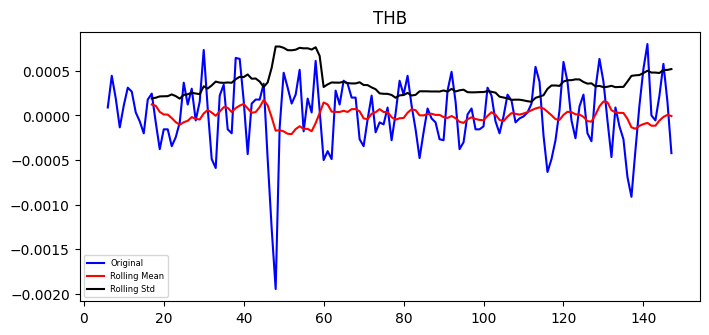

Open
ADF Statistic: -4.207241282377436
p-value: 0.0006405479906362908
Critical Values:
	1%: -3.482087964046026
	5%: -2.8842185101614626
	10%: -2.578864381347275


In [7]:

def I1(df):
    shifted=log_m_mean(df_rolling(df))
    shifted.dropna(inplace=True)
    return shifted
#The I model
def I(df):
    dt = shift(I1(df))
    dt.dropna(inplace=True)
    return dt

ca.df=I(ca.df_log())
ca.stationarity()

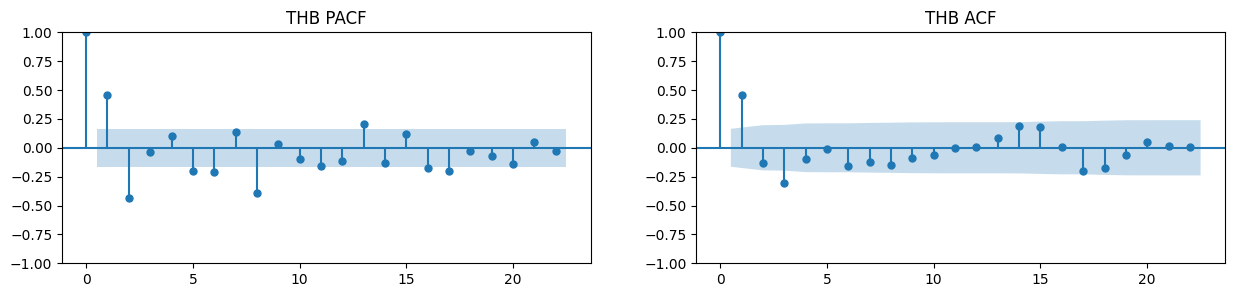

In [8]:
ca.plot_autocorr_fun()

In [9]:
ca.best_parameters_autocorr_fun()
#p+d, q = ca.best_parameters_autocorr_fun() = 3,2
# => Let p=2,d=1 (included in the model I, so parameter d=0 for the ARIMA model), q=2

(3, 2)

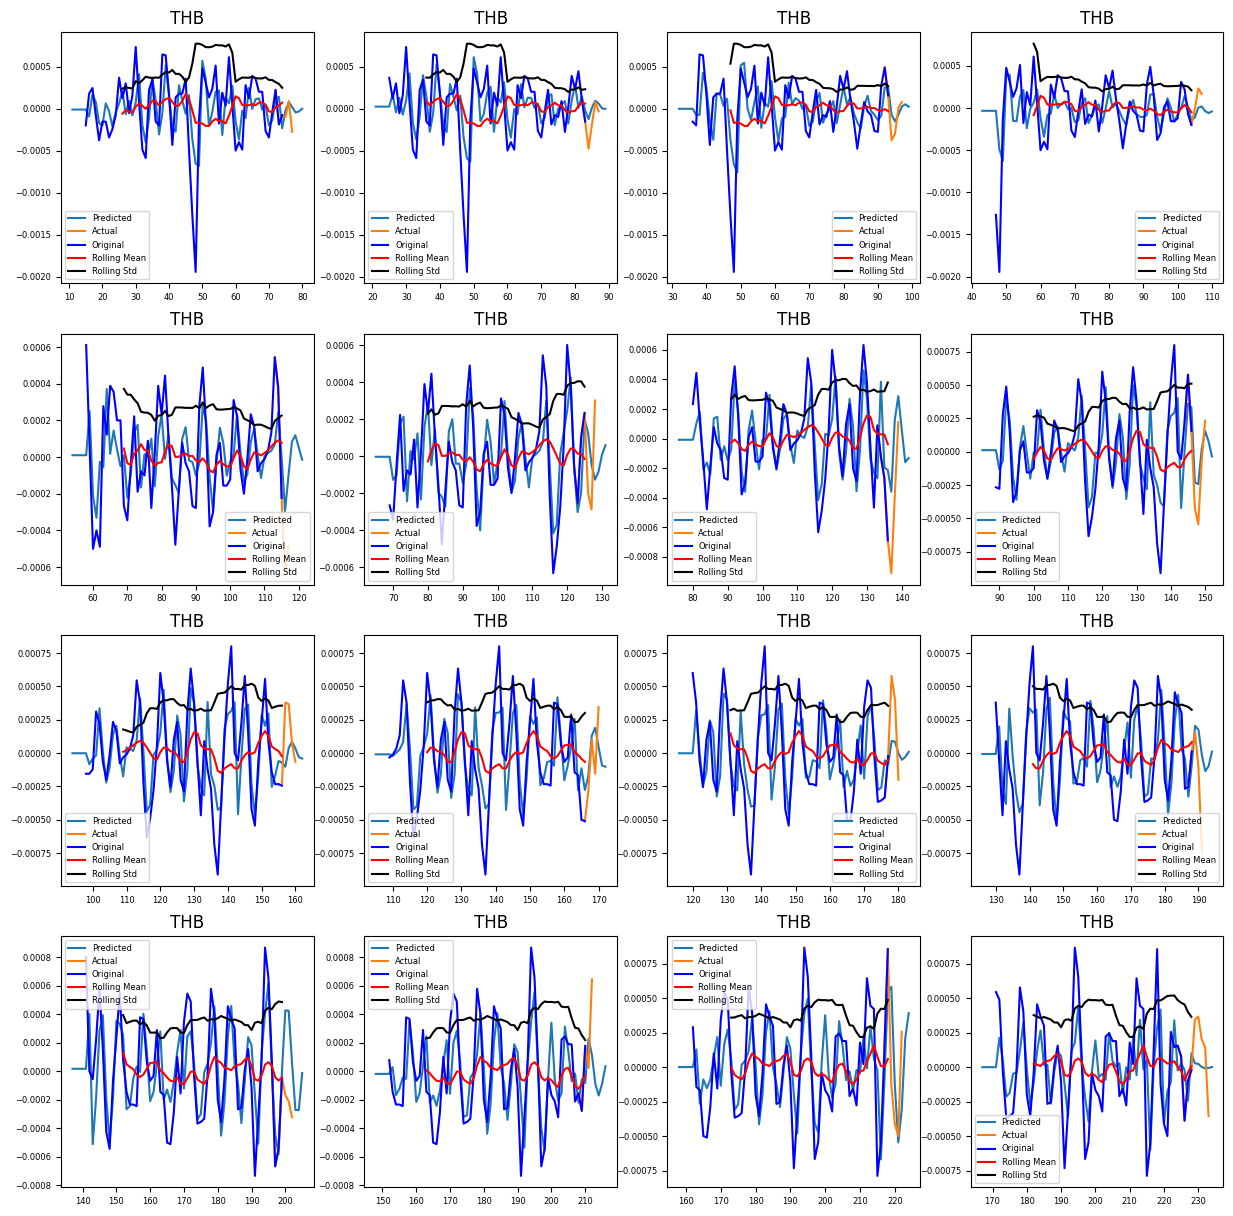

In [10]:
test_days=5

p=2 # AR order
d=0 # differencing order
q=4 # MA order

#Select data in range [date_min,date_max]
date_min=pd.to_datetime("2022.01.01")
date_max=pd.to_datetime("2022.04.01")
date_diff=15
min_train_sampsize=30 #1 month

fig,axes=plt.subplots(4,4,figsize=(15,15))
validations=[]

def thb_by_date():
    global date_min,date_max
    return CurrencyAnalysis(alpha,df_currencies,'1 THB',date_min,date_max,test_days,'THB')

for _ax in axes:
    stop=False
    for ax in _ax:
        date_min+=timedelta(date_diff)
        date_max+=timedelta(date_diff)
        try:
            currency_analysis_iter(ax,p,d,q,thb_by_date)
        except:
            stop=True
            break
    if stop:
        break

fig.show()

In [11]:
def draw_validation_plot(validations):
    fig1,axes1=plt.subplots(4,4,figsize=(15,8))

    i=0
    for _ax in axes1:
        stop=False
        for ax in _ax:
            if i>=len(validations):
                stop=True
                break
            val=validations[i]
            i+=1
            ax.plot(val[0],label="expected")
            ax.plot(val[1], color='red',label="fitted values")
            ax.legend(fontsize=6)

    fig1.show()
#draw_validation_plot(validations)

In [12]:
p=2 # AR order
d=0 # differencing order
q=2 # MA order

for d1 in range(0,2):
    for d2 in range(-2,3):
        ca.arima_build(p+d1,d,q+d2,Integration_fun=I,plot=False)
        s=ca.summary()
        aic=s.tables[0].data[2][3]
        print("for parameters (%d,%d,%d): AIC = %s"%(p+d1,d,q+d2,aic))

for parameters (2,0,0): AIC = -1894.610
for parameters (2,0,1): AIC = -1892.743
for parameters (2,0,2): AIC = -1896.264
for parameters (2,0,3): AIC = -1908.267
for parameters (2,0,4): AIC = -1913.327
for parameters (3,0,0): AIC = -1892.866
for parameters (3,0,1): AIC = -1891.414
for parameters (3,0,2): AIC = -1825.040
for parameters (3,0,3): AIC = -1823.043
for parameters (3,0,4): AIC = -1794.292


In [13]:
p=2
d=0
q=4
ca.arima_build(p,d,q,Integration_fun=I,plot=False)
ca.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  1 THB   No. Observations:                  142
Model:                 ARIMA(2, 0, 4)   Log Likelihood                 964.664
Date:                Sun, 08 Jan 2023   AIC                          -1913.327
Time:                        11:48:17   BIC                          -1889.680
Sample:                             0   HQIC                         -1903.718
                                - 142                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -5.101e-06   1.12e-05     -0.456      0.648    -2.7e-05    1.68e-05
ar.L1          0.0654      0.048      1.364      0.173      -0.029       0.159
ar.L2          0.2137      0.121      1.769      0.077      -0.023       0.450
ma.L1          0.5988      0.056     10.723      0.000       0.489       0.708
ma.L2         -0.2546      0.132     -1.930      0.054      -0.513       0.004
ma.L3         -0.7364      0.068    -10.810      0.000      -0.870      -0.603
ma.L4         -0.3441      0.072     -4.782      0.000      -0.485      -0.203
sigma2      7.176e-08   8.63e-09      8.319      0.000    5.49e-08    8.87e-08
===================================================================================
Ljung-Box (L1) (Q):                   0.58   Jarque-Bera (JB):                12.80
Prob(Q):                              0.45   Prob(JB):                         0.00
Heteroskedasticity (H):               0.52   Skew:                            -0.28
Prob(H) (two-sided):                  0.03   Kurtosis:                         4.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.05e+16. Standard errors may be unstable.
"""

### 1.2  Forecasting of the exchange rates between USD-BTC

In [14]:
test_days=10


#Select data in range [date_min,date_max]
date_min=pd.to_datetime("2020.01.01")
date_max=pd.to_datetime("2020.10.01")

#The name of the dataset column to analyze
col='Open'

#Dogecoin dataset (unused in this project)
df_doge="coin_Dogecoin.csv"
#Bitcoin dataset
df_btc="coin_Bitcoin.csv"

btc=CurrencyAnalysis(alpha=alpha,df_name=df_btc,col=col,date_min=date_min,date_max=date_max,currency_name='BTC',
                    test_days=test_days)
    

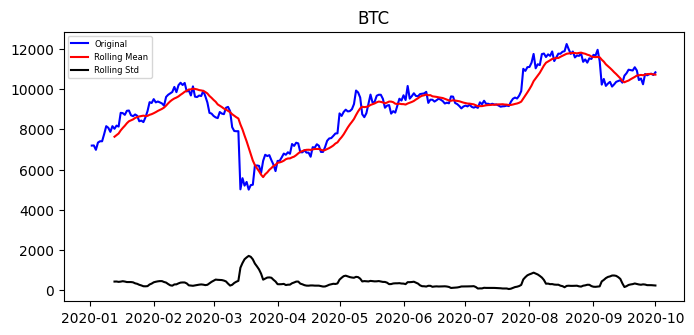

Open
ADF Statistic: -1.7860178705409633
p-value: 0.38742519439841405
Critical Values:
	1%: -3.4547128138328875
	5%: -2.8722649771800155
	10%: -2.5724850011573914


In [15]:
btc.stationarity()

In [16]:
def I1(df):
    shifted=log_m_mean(df_rolling(df))
    shifted.dropna(inplace=True)
    return shifted
def I(df):
    dt = shift(I1(df))
    dt.dropna(inplace=True)
    return dt
btc.df=I(btc.df_log())

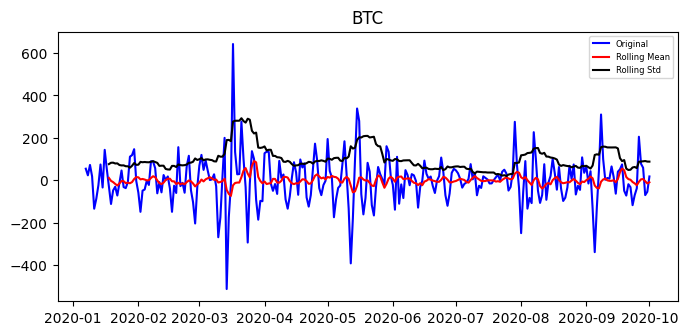

Open
ADF Statistic: -9.190309644461324
p-value: 2.132133699796353e-15
Critical Values:
	1%: -3.4560535712549925
	5%: -2.8728527662442334
	10%: -2.5727985212493754


In [17]:
btc.stationarity()

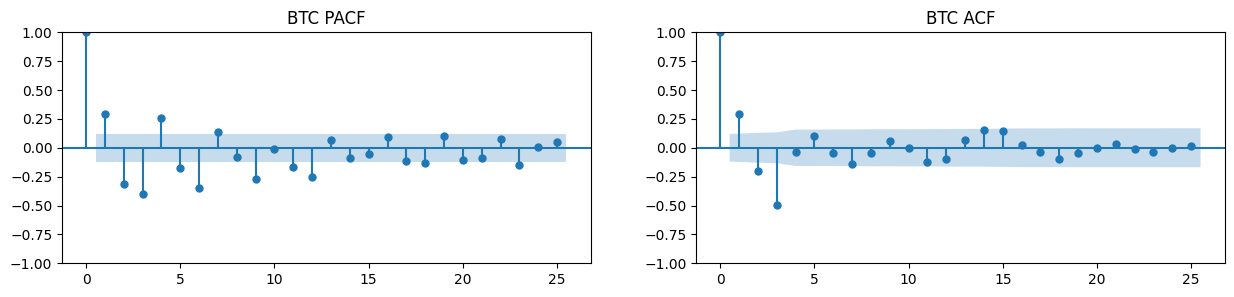

In [18]:
btc.plot_autocorr_fun()

In [19]:
btc.best_parameters_autocorr_fun()
#p+d, q = btc.best_parameters_autocorr_fun() = 8,4
# => Let p=7,d=1 (included in the model I, so parameter d=0 for the ARIMA model), q=4

(8, 4)

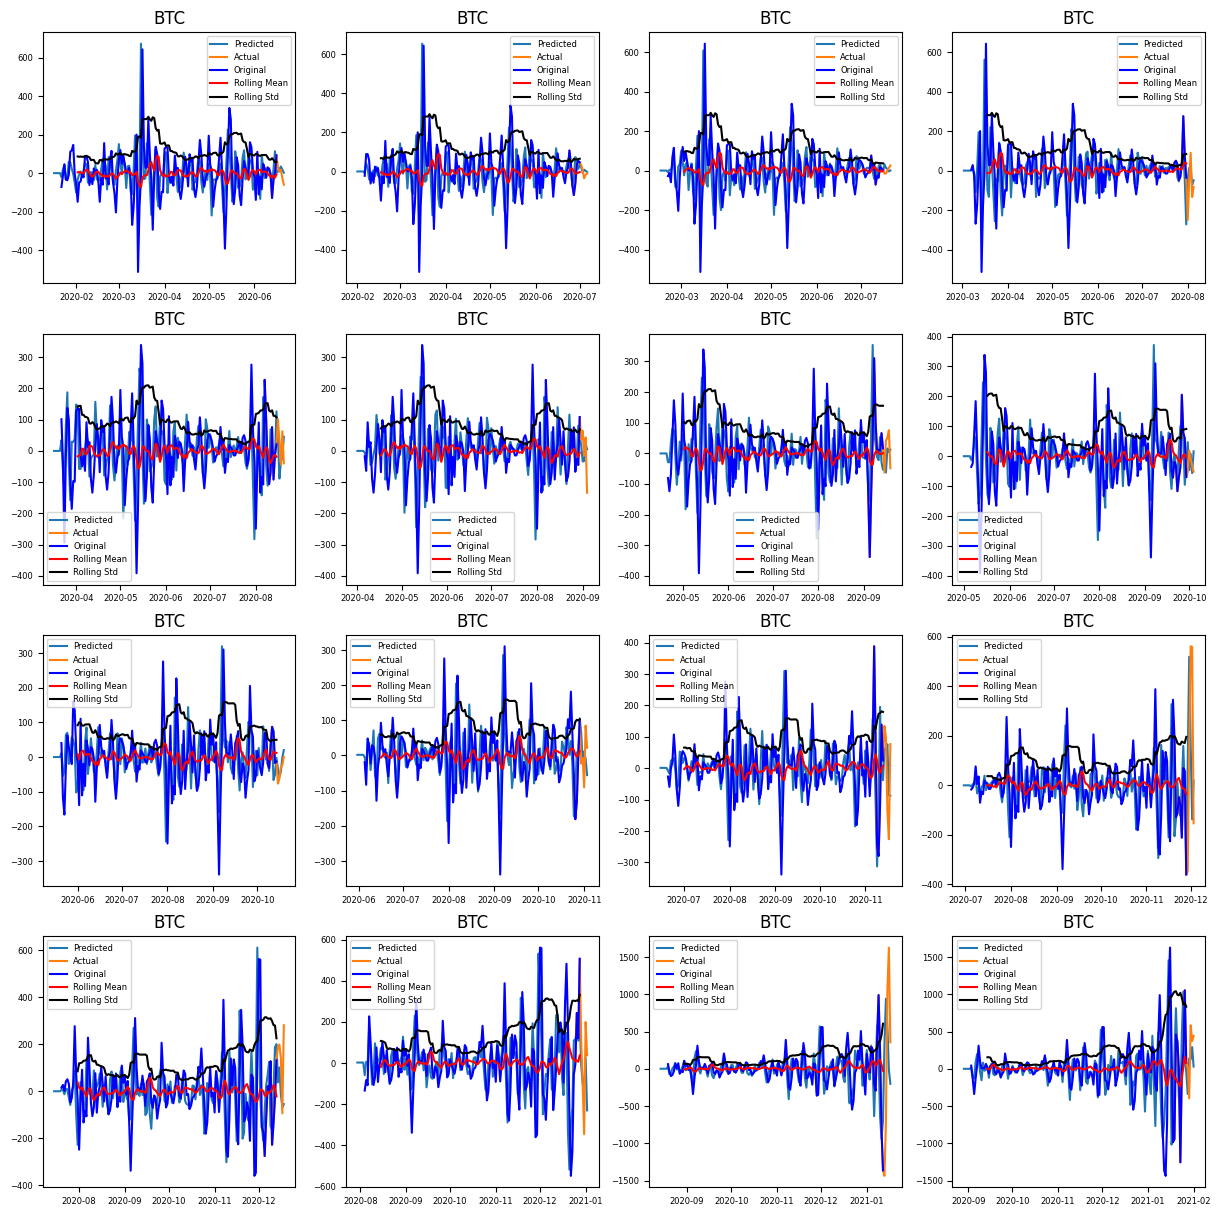

In [20]:
test_days=5

p=8 # AR order
d=0 # differencing order
q=3 # MA order

#Select data in range [date_min,date_max]
date_min=pd.to_datetime("2020.01.01")
date_max=pd.to_datetime("2020.06.01")
date_diff=15
min_train_sampsize=30 #1 month

fig,axes=plt.subplots(4,4,figsize=(15,15))
validations=[]

def btc_by_date():
    global date_min,date_max
    return CurrencyAnalysis(alpha=alpha,df_name=df_btc,col=col,date_min=date_min,date_max=date_max,currency_name='BTC',
                    test_days=test_days)

for _ax in axes:
    stop=False
    for ax in _ax:
        date_min+=timedelta(date_diff)
        date_max+=timedelta(date_diff)
        try:
            currency_analysis_iter(ax,p,d,q,btc_by_date)
        except Exception as e:
            print(e)
            stop=True
            break
    if stop:
        break

fig.show()

In [21]:
#draw_validation_plot(validations)

In [22]:
p=7 # AR order
d=0 # differencing order
q=4 # MA order

for d1 in range(0,2):
    for d2 in range(-4,2):
        btc.arima_build(p+d1,d,q+d2,Integration_fun=I,plot=False)
        s=btc.summary()
        aic=s.tables[0].data[2][3]
        print("for parameters (%d,%d,%d): AIC = %s"%(p+d1,d,q+d2,aic))

for parameters (7,0,0): AIC = 3151.040
for parameters (7,0,1): AIC = 3152.685
for parameters (7,0,2): AIC = 3118.314
for parameters (7,0,3): AIC = 3097.087
for parameters (7,0,4): AIC = 3098.022
for parameters (7,0,5): AIC = 3098.377
for parameters (8,0,0): AIC = 3151.341
for parameters (8,0,1): AIC = 3128.850
for parameters (8,0,2): AIC = 3115.368
for parameters (8,0,3): AIC = 3095.000
for parameters (8,0,4): AIC = 3098.033
for parameters (8,0,5): AIC = 3100.233


In [23]:
p=8
d=0
q=3
btc.arima_build(p,d,q,Integration_fun=I,plot=False)
btc.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   Open   No. Observations:                  269
Model:                 ARIMA(8, 0, 3)   Log Likelihood               -1534.500
Date:                Sun, 08 Jan 2023   AIC                           3095.000
Time:                        11:48:38   BIC                           3141.731
Sample:                    01-06-2020   HQIC                          3113.767
                         - 09-30-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0185      0.375     -0.049      0.961      -0.754       0.717
ar.L1          0.3876      0.082      4.752      0.000       0.228       0.547
ar.L2         -0.1053      0.122     -0.865      0.387      -0.344       0.133
ar.L3         -0.0095      0.098     -0.097      0.922      -0.201       0.182
ar.L4          0.0847      0.098      0.864      0.388      -0.107       0.277
ar.L5          0.0322      0.087      0.370      0.711      -0.138       0.203
ar.L6         -0.0466      0.095     -0.492      0.623      -0.233       0.139
ar.L7         -0.0599      0.063     -0.947      0.344      -0.184       0.064
ar.L8          0.0034      0.082      0.042      0.967      -0.158       0.165
ma.L1          0.0051      8.899      0.001      1.000     -17.436      17.446
ma.L2         -0.0049      8.820     -0.001      1.000     -17.292      17.283
ma.L3         -0.9999     17.111     -0.058      0.953     -34.536      32.536
sigma2      5008.3848   8.56e+04      0.058      0.953   -1.63e+05    1.73e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              5682.17
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               0.45   Skew:                            -2.44
Prob(H) (two-sided):                  0.00   Kurtosis:                        24.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Conclusions
- PLN-THB analysis:
    - Model definition: ARIMA(2,0,4)
    - Integration model: $X \rightarrow \text{shift}(X - \text{rolling mean of X (window = 3))}$
    - The AIC value of ARIMA(2,0,4) model which, is used for PLN-THB time series forecasting is equal to -1913, which is the minimum estimator value for chosen models. The Akaike Information criterion estimates the prediction error and relative quality of a statistical model (higher information loss in the estimation process will result in higher AIC estimator value). 
    - Based on ACF & PACF functions: p=2, q=2; Parameter values based on the AIC estimator: p=2, q=4
    - Because ACF & PACF parameter estimation may result in overfitting the model, the best model parameters are chosen according to the AIC estimator results
- USD-BTC analysis:
    - Model definition: ARIMA(8,0,3)
    - Integration model: $X \rightarrow \text{shift}(X - \text{rolling mean of X (window = 3))}$
    - The AIC value of ARIMA(8,0,3) model, which is used for USD-BTC time series forecasting is equal to 3095, which is the minimum estimator value for chosen models.
    - Based on ACF & PACF : p=7, q=4; Parameter values based on the AIC estimator: p=8, q=3